In [1]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

import tf_lab.point_clouds.in_out as pio
from tf_lab.point_clouds.in_out import PointCloudDataSet

from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf

from general_tools.in_out.basics import create_dir, delete_files_in_directory
from geo_tool import Point_Cloud

from general_tools.in_out.basics import files_in_subdirs
from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id

/orions4-zfs/projects/lins2/Panos_Space/Git_Repos/geo_tool/solids/mesh.py:26: UserWarning: Mayavi library was not found. Some graphics utilities will be disabled.
  warnings.warn('Mayavi library was not found. Some graphics utilities will be disabled.')


In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
from tensorflow.python.client import device_lib
device_lib.list_local_devices()


# from tf_lab.fundamentals.utils import set_visible_GPUs
# set_visible_GPUs([1])

[name: "/cpu:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2920342356228259642, name: "/gpu:0"
 device_type: "GPU"
 memory_limit: 3299278848
 locality {
   bus_id: 1
 }
 incarnation: 15457724664715551672
 physical_device_desc: "device: 0, name: TITAN X (Pascal), pci bus id: 0000:02:00.0"]

In [14]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
seed = 42
np.random.seed(seed)
tf.set_random_seed(seed)

class_type = raw_input('Give me the class type.').lower()
class_syn_id = shape_net_category_to_synth_id()[class_type]
top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'
full_pclouds_path = osp.join(top_data_dir, 'ShapeNetPointClouds/from_manifold_meshes/1024/', class_syn_id)
train_dir = osp.join(top_data_dir, 'OUT/models/')
experiment_name = 'virt_scan_' + class_syn_id + '_only_ae'
train_dir = osp.join(train_dir, experiment_name)
create_dir(train_dir)

Give me the class type.chair


'/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/virt_scan_03001627_only_ae'

In [5]:
full_file_names = pio.load_filenames_of_input_data(full_pclouds_path)
full_pclouds, full_model_names, class_ids = pio.load_crude_point_clouds(file_names=full_file_names, n_threads=11)
print '%d files containing complete point clouds were found.' % (len(full_pclouds), )

6778 files containing complete point clouds were found.


In [6]:
virtual_scan_data = osp.join(top_data_dir, 'From_Mathhias/shapenet_dim32_sdf_pc', class_syn_id)
noisy_pcloud_files = pio.load_filenames_of_input_data(virtual_scan_data, pio.vscan_search_pattern)
print '%d files containing noisy point clouds were found.' % (len(noisy_pcloud_files), )
noisy_pclouds, noisy_model_names, class_ids = pio.load_crude_point_clouds(file_names=noisy_pcloud_files, 
                                                                n_threads=11, 
                                                                loader=pio._load_virtual_scan_incomplete_pcloud)

6000 files containing noisy point clouds were found.


In [7]:
# match incomplete to complete (no class here)
d = {name:i for i, name in enumerate(full_model_names)}
mapping = [] # The i-th noisy pcloud will correspond to the mapping[i] in the original order.
for name in noisy_model_names:
    mapping.append(d[name])
mapping = np.array(mapping)
full_pclouds_matched = full_pclouds[mapping]

In [8]:
train_data_, _, test_data_ = pio.train_validate_test_split([full_pclouds_matched,
                                                            noisy_pclouds, 
                                                            noisy_model_names],
                                                            train_perc=0.9,
                                                            validate_perc=0.0,
                                                            test_perc=0.1,
                                                            seed=seed)

train_data = PointCloudDataSet(train_data_[0], noise=train_data_[1], labels=train_data_[2])
test_data = PointCloudDataSet(test_data_[0], noise=test_data_[1], labels=test_data_[2])

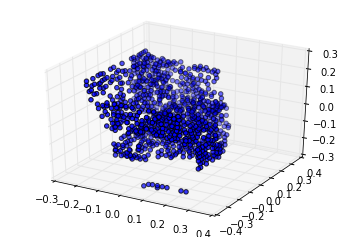

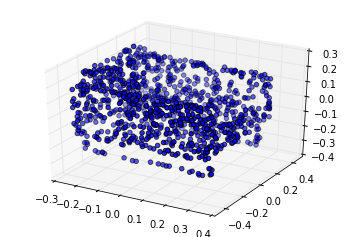

In [9]:
# TRY ME.
pp = test_data.next_batch(1)
Point_Cloud(points=pp[2].reshape(1024, 3)).plot();
Point_Cloud(points=pp[0].reshape(1024, 3)).plot();

In [10]:
import tf_lab.models.point_net_based_AE as pnAE

def reset_graph():
    if 'sess' in globals() and sess:
        sess.close()
    tf.reset_default_graph()


conf = Conf(n_input = [1024, 3],
               training_epochs = 1000,
               batch_size = 40,
               loss = 'Chamfer',
               train_dir = train_dir,
               loss_display_step = 1,
               saver_step = 5,
               learning_rate = 0.0002,
               saver_max_to_keep = 200,
               gauss_augment = {'mu': 0, 'sigma': 0.02},
               encoder = pnAE.encoder,
               decoder = pnAE.decoder,
               spatial_trans = True,             
               denoising = True
              )

reset_graph()

ae = PointNetAutoEncoder(experiment_name, conf)

if conf.debug:
    ae.train_names = set(train_data_[2])

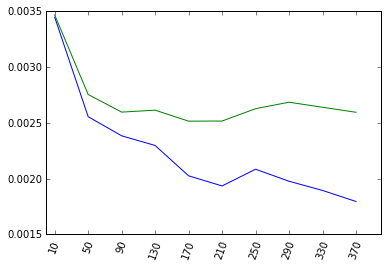

In [15]:
# stats = ?
# fig, ax = plt.subplots();
# x = range(10, 400, 40);
# plt.plot(x, stats[:,1]);
# plt.plot(x, stats[:,2]);
# plt.xticks(rotation=70);
# ax.set_xticks(x);

In [31]:
# # from tf_lab.autopredictors.plotting.basics import plot_original_pclouds_vs_reconstructed
# # ae.restore_model(conf.train_dir, 490, verbose=True)

# from tf_lab.autopredictors.evaluate.basics import eval_model
# eval_model(ae, conf, [], epochs=[], verbose=True)



In [30]:
# reconstructed, loss, feed, gt_feed = ae.evaluate(train_data, conf, return_feed=True)
# save_dir = osp.join(top_data_dir, 'OUT/model_evaluation/train_data_490_epoch')
# create_dir(save_dir)
# plot_original_pclouds_vs_reconstructed(feed, reconstructed, gt_feed, save_dir, max_plot=200)